In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Read the pickle file
with open("../tracker_stubs/ball_detections.pkl", "rb") as fh:
    ball_positions = pickle.load(fh)

In [7]:
ball_positions = [x.get(1, []) for x in ball_positions]

# Convert list to pandas DataFrame
df_ball_positions = pd.DataFrame(
    ball_positions, columns=["x1", "y1", "x2", "y2"]
)

# Interpolate the missing values
df_ball_positions = df_ball_positions.interpolate().bfill()

ball_positions = [{1: x} for x in df_ball_positions.to_numpy().tolist()]


In [9]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

<Axes: >

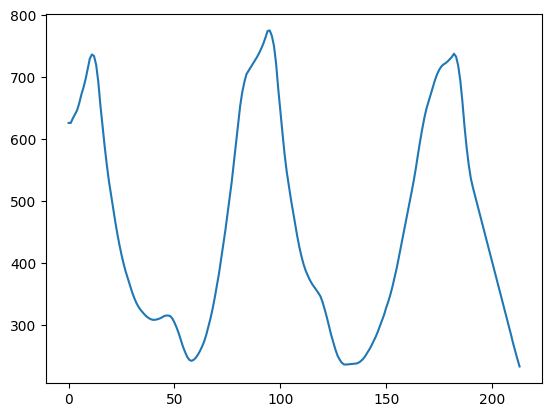

In [15]:
df_ball_positions['mid_y_rolling_mean'].plot()

<Axes: >

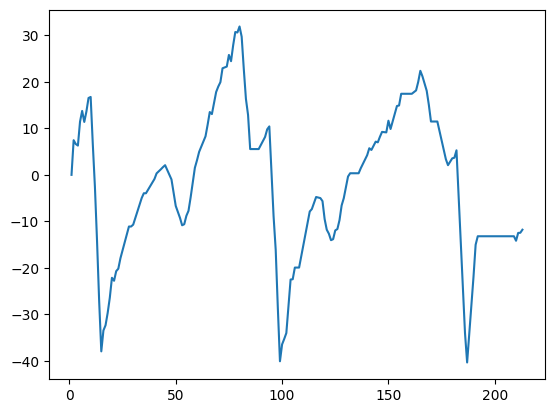

In [16]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()
df_ball_positions['delta_y'].plot()

In [17]:
df_ball_positions['ball_hit'] = 0

In [26]:
minimum_change_frames_for_hit = 25
for i in range(1, len(df_ball_positions) - int(1.2 * minimum_change_frames_for_hit)):
    negative_position_change = df_ball_positions.loc[i, 'delta_y'] > 0 and df_ball_positions.loc[i+1, 'delta_y'] < 0
    positive_position_change = df_ball_positions.loc[i, 'delta_y'] < 0 and df_ball_positions.loc[i+1, 'delta_y'] > 0

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i + 1, i + 1 + int(1.2 * minimum_change_frames_for_hit)):
            negative_position_change_following_frame = df_ball_positions.loc[i, 'delta_y'] > 0 and df_ball_positions.loc[change_frame, 'delta_y'] < 0
            positive_position_change_following_frame = df_ball_positions.loc[i, 'delta_y'] < 0 and df_ball_positions.loc[change_frame, 'delta_y'] > 0

            if negative_position_change and negative_position_change_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_following_frame:
                change_count += 1

        if change_count >= minimum_change_frames_for_hit:
            df_ball_positions.loc[i, 'ball_hit'] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()

In [21]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,777.792664,717.570801,797.881531,738.437622,728.004211,736.467529,6.652747,1
58,925.894995,239.744339,938.448450,253.060797,246.402568,241.729618,-1.658584,1
95,624.132965,748.342346,641.682007,766.125732,757.234039,775.237299,0.768036,1
131,714.293165,229.050166,728.666416,243.855779,236.452972,235.764954,-0.361559,1
182,1293.604736,739.002319,1315.897095,759.592529,749.297424,737.635126,5.274292,1
